<a href="https://colab.research.google.com/github/rakibulhaque9954/Machine_Learning_Translation/blob/main/Machine_translation_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acknowledgement

**Based on research by members of Google Brain, Google Research, Univerity of Toronto**<br>
Paper Link: https://arxiv.org/pdf/1706.03762.pdf


# Imports

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from keras.models import Model
from keras.layers import Layer
from keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.layers import MultiHeadAttention, LayerNormalization
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

## Dataset Download

In [2]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2023-10-28 12:27:40--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757635 (7.4M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.40M  17.5MB/s    in 0.4s    

2023-10-28 12:27:41 (17.5 MB/s) - ‘fra-eng.zip’ saved [7757635/7757635]



In [3]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Kaggle Dataset

In [4]:
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download -d dhruvildave/en-fr-translation-dataset
# !unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"


In [5]:
# dataset = tf.data.experimental.CsvDataset(
#     "/content/dataset/en-fr.csv",
#     [tf.string, tf.string],
#     header=True  # Assumes the CSV file has a header
# )

# !mkdir /content/dataset1

# with open("/content/dataset/en-fr.txt", "w") as f:
#     for english, french in dataset:
#         # Convert TensorFlow tensors to Python strings
#         english_str = english.numpy().decode("utf-8")
#         french_str = french.numpy().decode("utf-8")

#         # Write to the text file, separating the two languages by a tab character
#         f.write(f"{english_str}\t{french_str}\n")

In [6]:
# for i in dataset.take(3):
#   print(i)

## Data Preprocessing

In [4]:
text_dataset = tf.data.TextLineDataset("/content/dataset/fra.txt")

In [5]:
for i in text_dataset.take(3):
  print(i)


tf.Tensor(b'Go.\tVa !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)', shape=(), dtype=string)
tf.Tensor(b'Go.\tMarche.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)', shape=(), dtype=string)
tf.Tensor(b'Go.\tEn route !\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)', shape=(), dtype=string)


In [6]:
VOCAB_SIZE = 20000
ENGLISH_SEQUENCE_LENGTH = 32
FRENCH_SEQUENCE_LENGTH = 32
EMBEDDING_DIM = 512
BATCH_SIZE = 128

In [7]:
english_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [8]:
french_vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [9]:
def selector(input_text):
  split_text = tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [10]:
split_dataset = text_dataset.map(selector)

In [11]:
def separator(input_text):
  split_text = tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [12]:
init_dataset = text_dataset.map(separator)

In [13]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


### Vocabulary Creation

In [14]:
english_training_data=init_dataset.map(lambda x,y:x) # input x,y and output x
english_vectorize_layer.adapt(english_training_data) # adapt the vectorize_layer to the training data

french_training_data=init_dataset.map(lambda x,y:y) # input x,y,z and output y
french_vectorize_layer.adapt(french_training_data) # adapt the vectorize_layer to the training data

### Grouping and Vectorizing for training

In [15]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [16]:
split_dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [17]:
dataset=split_dataset.map(vectorizer)

In [18]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken En route !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'En route ! endtoken'], dtype=object)>)


In [19]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[  2, 103,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 32), dtype=int64, numpy=
array([[103,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])>)


In [20]:
dataset

<_MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

In [21]:
dataset = dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [22]:
dataset

<_PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

In [23]:
NUM_BATCHES = int(200000/BATCH_SIZE)

### Dataset Split

In [24]:
train_dataset = dataset.take(int(0.9*NUM_BATCHES))
val_dataset = dataset.skip(int(0.9*NUM_BATCHES))

In [25]:
train_dataset

<_TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 32), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 32), dtype=tf.int64, name=None))>

# Modeling

<hr>
<h4>Model Architecture</h4>
<hr>
<img src='https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png'>

***Step Wise Explanation:***
- Input Embedding: The process begins with encoding the input language (e.g., English sequence) into numerical vectors. Each word or token is transformed into a high-dimensional vector.
- Multi-Head Self-Attention: This is the heart of a transformer. The model looks at each word in the input sentence and assigns different levels of importance to other words in the sentence. Multiple attention heads allow the model to focus on different aspects of the sentence simultaneously.
- Positional Encoding: Since transformers don't have an inherent sense of word order, positional encoding is added to the word embeddings to help the model understand the word's position in the sentence.
- Encoder-Decoder Architecture: In translation tasks, there are typically two parts: the encoder and the decoder. The encoder takes the input sentence and processes it, while the decoder generates the translated output.
- Decoder Self-Attention: The decoder also uses multi-head self-attention, but it's slightly modified to prevent it from looking ahead in the output sentence, which would result in incorrect translations.
- Attention Output: The outputs from the attention mechanisms are used to calculate attention scores, which determine how much each word in the input sentence contributes to each word in the output sentence.
Position-wise Feedforward Networks: After attention, the model passes the data through feedforward neural networks to further process and refine the information.
Output Layer: The final layer in the decoder produces probabilities for each word in the target language vocabulary, allowing the model to predict the next word in the translation.
- Training and Optimization: Transformers are trained using large parallel corpora of source and target language sentences. They learn to minimize the difference between predicted translations and the actual translations in the training data.
- Repeat for Each Token: This process is repeated for each word in the output sentence, where the previously generated words are used as context for generating the next word.
Beam Search or Greedy Decoding: During inference, the model generates translations one word at a time. Beam search or greedy decoding is often used to select the most likely next word based on the model's predictions.

<h4>Inside Attention Layer</h4>
<img src='https://production-media.paperswithcode.com/methods/35184258-10f5-4cd0-8de3-bd9bc8f88dc3.png'>

Easy to understand Explanation:

Lets break it down and relate it to the components and processes in a transformer model:

- School and Students: Think of the school as the entire context, and the students as the individual tokens in a sequence.
- Vectorization and Tokenization: The process of converting students into tokens and vectorizing them represents the initial preprocessing steps where text data is tokenized into individual words or tokens and then converted into numerical vector representations.
- Vocabulary: The vocabulary of the school represents the set of unique tokens (students) that the model has learned from various schools within the same company. These tokens are used to represent words in the sequences.
- Intra-Attention (Self-Attention):
Each student's interaction with their classmates represents the intra-attention mechanism, where relationships, influences, and context between tokens (students) are captured.
Each student becomes a query (Q), and their classmates become keys (K) and values (V).
Attention scores are calculated to determine how much weight each student should give to their classmates.
Softmax normalization of attention scores can be thought of as grading each student's relationships and influence on others.
Concatenation of information from different teachers (heads) captures diverse insights.
- Inter-Attention (Cross-Attention):
When different classes (decoders) want to compare their students (tokens), it's akin to cross-attention between different parts of the model.
A student from one class becomes a query (Q), and the students from another class become keys (K) and values (V).
The process is similar to intra-attention but operates across different classes.
- Linear Layer: The linear layer represents the post-attention processing step that helps combine and refine information before producing the final output.

This is the essence of how attention mechanisms work in transformers, where tokens (students) attend to each other, calculate their influence, and produce context vectors (mark sheets) for each other. These context vectors are then used in cross-attention to compare tokens from different parts of the model, ultimately leading to the model's final output.

Encoder's Role (Intra-Attention in Encoder):
The encoder processes the input sequence and performs intra-attention.
It produces context vectors (contextual representations) for each word in the input sequence.
These context vectors capture information about how each word relates to others within the input sequence.

Signaling the Decoder:
The decoder is signaled to start generating the output sequence.
Typically, this is done by providing the decoder with an initial input, often a special start token (e.g., <START> or <SOS>).

Generating the First Word:
For the first word in the output sequence, the decoder combines the following:
The start token as the initial query.
The encoder's context vectors, which represent the input sequence.
The decoder's own context vector for the output sequence (initialized explicitly).
These components are used to predict the first word in the output sequence.

Subsequent Word Predictions:
For generating subsequent words in the output sequence, the following process occurs:
The shifted target (previously generated word) becomes the query.
The encoder's context vectors, representing the input sequence, are used for context.
The context vectors for the target word (which includes context from the encoder) are also considered.
The last word's hidden state, obtained from the decoder's self-attention (intra-attention), is incorporated.
These components collectively contribute to the prediction of each subsequent word in the output sequence.

Iterative Token Generation:
The decoder repeats the process of generating tokens one by one, considering context from both the encoder's input sequence and its own generated sequence.
At each step, the decoder calculates a probability distribution over the vocabulary for the next token and selects the token with the highest probability.

Ending the Sequence:
The process continues until the model generates an end token (e.g., <END> or <EOS>) or reaches a predefined maximum sequence length.

## Transformers Architecture

<img src="https://www.mihaileric.com/static/feedforward_layer_and_normalization-dfdcfbd00009f7f99eca73ae29f2dfb7-4ec3a.png">

### Positional Encoding

In [26]:
def positional_encoding(model_size, SEQUENCE_LENGTH): # d_model
  output = []
  for pos in range(SEQUENCE_LENGTH):
    PE = np.zeros((model_size)) # initilizing with zeros
    for i in range(model_size):
      if i % 2 == 0: # even positions, sin formula is used according to paper
        PE[i] = np.sin(pos/(10000**(i/model_size)))
      else: # odd positions, cos formula is used as mentioned in the paper
        PE[i] = np.cos(pos/(10000**((i-1)/model_size)))
    output.append(tf.expand_dims(PE, axis = 0))

  out = tf.concat(output, axis=0)
  out = tf.expand_dims(out, axis=0)
  return tf.cast(out, dtype=tf.float32)

In [74]:
print(positional_encoding(256, 32).shape)

(1, 32, 256)


### Input Embeddings

In [27]:
class Embeddings(Layer):
  def __init__(self, sequence_length, vocab_size, embedding_dim):
    super(Embeddings, self).__init__()
    self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim

  def call(self, inputs):
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = positional_encoding(self.embedding_dim, self.sequence_length) # PE adding here
    return embedded_tokens + embedded_positions # final output for inputs

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0) # masking function for checking if there are pad tokens(0)



In [76]:
# testing

# test_input = tf.constant([[1, 2, 3, 4, 0, 0, 0]])
# embeddings_layer = Embeddings(sequence_length=7, vocab_size=20000, embedding_dim=256)
# output_embed = embeddings_layer(test_input)
# print(output_embed.shape)
# mask = embeddings_layer.compute_mask(test_input)
# print(mask)

# output: [Batch, Sequence_length, Embedding_dims]
# for each and every input there is vector with Embedding dimension 256
# for zeros in the input the mask was computed and it was not considered since they are zeros(pad_tokens)

In [77]:
# padding_mask = tf.cast(
#     tf.repeat(mask,repeats=tf.shape(mask)[1],axis=0),
#     dtype=tf.int32)
# print(padding_mask)

### Custom Attention Layers



**Self Attention Layer**
<hr>

In [78]:
class CustomSelfAttention(Layer):
  def __init__(self, model_size):
    super(CustomSelfAttention, self).__init__()
    self.model_size = model_size

  def call(self, query, key, value, masking):
    #### Compute Scores ####
    score = tf.matmul(query, key, transpose_b=True)

    #### Scaling ####
    score = score / tf.math.sqrt(tf.cast(self.model_size, dtype=tf.float32))

    #### Masking ####
    masking = tf.cast(masking, dtype=tf.float32)
    score -= (1.0 - masking) * 1e10

    #### Attention Weights ####
    attention_weights = tf.nn.softmax(score, axis=-1) * masking

    #### Weighted Sum ####
    head_output = tf.matmul(attention_weights, value)

    #### Output ####
    return head_output



**Multi-Head-Attention Layer**
<hr>

In [79]:
class CustomMultiHeadAttention(Layer):
  def __init__(self, num_heads, key_dim):
    super(CustomMultiHeadAttention, self).__init__()

    self.num_heads = num_heads
    self.dense_q = [Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_k = [Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_v = [Dense(key_dim//num_heads) for _ in range(num_heads)]
    self.dense_o = Dense(key_dim)
    self.attention = CustomSelfAttention(key_dim)

  def call(self, query, key, value, attention_mask):
    heads = []

    for i in range(self.num_heads): # for each head
      print(f'head-{i}', self.dense_q[i](query).shape)
      head = self.self_attention(self.dense_q[i](query), self.dense_k[i](key),
                                 self.dense_v[i](value), attention_mask)

      heads.append(head)
    heads = tf.concat(heads, axis=2) # concatenating all heads
    heads = self.dense_o(heads) # passing all heads through a linear layer for the final output
    return heads


### Encoder Layer

In [28]:
class TransformerEncoder(Layer):
  def __init__(self, embedding_dims, dense_dims, num_heads):
    super(TransformerEncoder, self).__init__()
    self.embedding_dims = embedding_dims
    self.dense_dims = dense_dims
    self.num_heads = num_heads
    self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dims)

    self.dense_proj = tf.keras.Sequential([
        Dense(self.dense_dims, activation="relu"),
        Dense(self.embedding_dims),
    ])
    self.layernorm_1 = LayerNormalization()
    self.layernorm_2 = LayerNormalization()
    self.supports_masking = True

  def call(self, inputs, mask=None):
    # print(mask)
    if mask is not None:
      mask = tf.cast(mask[:, tf.newaxis, :], dtype='int32')
      # print(mask)
      T = tf.shape(mask)[2]
      padding_mask = tf.repeat(mask, T, axis=1)
      # print(padding_mask)

    attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)

    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

In [81]:
##### Test for Encoder #####
# test_input = tf.random.uniform((1, 10, 256))
# test_mask = tf.cast(tf.random.uniform((1, 10)) > 0.5, tf.int32)
# encoder = TransformerEncoder(embedding_dims=256, dense_dims=512, num_heads=8)(output_embed)
# print(encoder.shape)


### Decoder

In [99]:
class TransformerDecoder(Layer):
  def __init__(self, embedding_dims, latent_dims, num_heads):
    super(TransformerDecoder, self).__init__()
    self.embedding_dims = embedding_dims
    self.latent_dims = latent_dims
    self.num_heads = num_heads
    self.attention_1 = MultiHeadAttention(
        num_heads=num_heads, key_dim=embedding_dims
    ) # self attention
    self.attention_2 = MultiHeadAttention(
        num_heads=num_heads, key_dim=embedding_dims
    ) # cross-attention with encoder's outputs
    self.dense_proj = tf.keras.Sequential(
        [Dense(latent_dims, activation='relu'), Dense(embedding_dims)]
    ) # feed forward layer
    self.layernorm_1 = LayerNormalization() # layer norm for all three layers as in paper
    self.layernorm_2 = LayerNormalization()
    self.layernorm_3 = LayerNormalization()
    self.supports_masking = True # this is special because of decoder

  def call (self, inputs, encoder_outputs, enc_mask, mask=None):

    if mask is not None:
      causal_mask = tf.linalg.band_part(
          tf.ones([tf.shape(inputs)[0],
                   tf.shape(inputs)[1],
                   tf.shape(inputs)[1]], dtype=tf.int32), -1, 0)
      # the role of causal mask is to prevent peeking into the future tokens for the decoder to predict better
      # the band_part method makes it really easier to do this

      mask = tf.cast(
          mask[:, tf.newaxis, :], dtype='int32'
      )
      enc_mask = tf.cast(
          enc_mask[:, tf.newaxis, :], dtype='int32'
      )

    T = tf.shape(mask)[2] # T is the number of queries from the decoder
    padding_mask = tf.repeat(mask, T, axis=1)
    cross_attn_mask = tf.repeat(enc_mask, T, axis=1)
    combined_mask = tf.minimum(padding_mask, causal_mask) # the full mask for the masked mutli-head-connection
    # print(f'Padding_mask: {padding_mask}')
    # print(f'Causal_mask: {causal_mask}')
    # print(f'Combined_mask: {combined_mask}')
    # print(f'Cross_attention_mask: {cross_attn_mask}')


    attention_output_1 = self.attention_1(
        query=inputs, key=inputs, value=inputs,
        attention_mask=combined_mask # the first layer which is the self attention for decoder
    )

    out_1 = self.layernorm_1(inputs + attention_output_1) # the first output + inputs added to be the input
    # for the cross_attention layer

    attention_output_2, scores = self.attention_2(
        query=out_1, key=encoder_outputs, value=encoder_outputs,
        attention_mask=cross_attn_mask,# the mask from cross attention just like encoder
        return_attention_scores=True
    )

    out_2 = self.layernorm_2(out_1 + attention_output_2) # output 2 after adding and normalizing to be passed
    # to feed forward layer for the final outputs

    proj_output = self.dense_proj(out_2)

    return self.layernorm_3(out_2 + proj_output), scores # the last norm layer

In [83]:
##### Test for Decoder #####
# enc_mask = mask
# decoder_outputs = TransformerDecoder(embedding_dims=256, latent_dims=512, num_heads=8)(output_embed, encoder, enc_mask)
# print(decoder_outputs.shape)



As you see the combined mask does not consider the pad tokens.
Lets define each of the mask roles:
- Padding mask - removes consideration of unnecessary pad tokens.
- Causal mask - Prevents from peeking in the future and helps decoder in predicting one token at a time.
- Cross-Attention mask - In the context of cross-attention between the encoder and decoder, a mask is used to ensure that the decoder only attends to positions in the encoder that have valid information. In this case, it can be similar to a padding mask when dealing with sequences of different lengths.
- Combined mask - takes the best of both world and  It ensures that the decoder doesn't include padding tokens in its consideration (like the padding mask) and enforces the autoregressive behavior (like the causal mask), allowing the decoder to predict one token at a time while avoiding future tokens.


In [84]:
# test for band_part method
# print(tf.linalg.band_part(tf.ones([10,10], dtype='int32'), -1, 0))

### Full Transfomers Model

In [100]:
EMBEDDING_DIMS = 512
LATENT_DIMS = 2048
NUM_HEADS = 8
NUM_LAYERS = 1
NUM_EPOCHS = 10
attention_scores = {}

In [114]:
encoder_inputs = Input(shape=(None,), dtype='int64', name='input_1')
embeddings = Embeddings(ENGLISH_SEQUENCE_LENGTH, VOCAB_SIZE, EMBEDDING_DIMS)
x = embeddings(encoder_inputs)
enc_mask = embeddings.compute_mask(encoder_inputs)


for _ in range(NUM_LAYERS): # there can be N number of layers as mentioned by paper
  x = TransformerEncoder(EMBEDDING_DIMS, LATENT_DIMS, NUM_HEADS)(x)
encoder_outputs = x

decoder_inputs = Input(shape=(None,), dtype='int64', name='input_2')
x = Embeddings(FRENCH_SEQUENCE_LENGTH, VOCAB_SIZE, EMBEDDING_DIMS)(decoder_inputs)

for i in range(NUM_LAYERS):
  x, scores = TransformerDecoder(EMBEDDING_DIMS, LATENT_DIMS, NUM_HEADS)(x, encoder_outputs, enc_mask)
  attention_scores[f'decoder_layer{i+1}_block2'] = scores

x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = Dense(VOCAB_SIZE, activation='softmax')(x)

attention_score_model = tf.keras.Model(
    [encoder_inputs, decoder_inputs],
    attention_scores, name='attention_score_model'
)


transformer = tf.keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs, name='transformer'
)

transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embeddings_49 (Embeddings)  (None, 32, 512)              1024000   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 embeddings_50 (Embeddings)  (None, 32, 512)              1024000   ['input_2[0][0]']   

# Training

## BLEU Metric

In [87]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words

    def result(self):
        return self.bleu_score/BATCH_SIZE

## Learning Rate Schedular

In [102]:
from keras.optimizers.schedules import LearningRateSchedule

class Scheduler(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps):
    """ Based on paper """
    super(Scheduler, self).__init__()
    self.d_model = tf.cast(d_model, tf.float64)
    self.warmup_steps = tf.cast(warmup_steps, dtype=tf.float64)

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float64)
    return (self.d_model**(-0.5))*tf.math.minimum(step**(-0.5), step * (self.warmup_steps ** -1.5))
    # as the number of steps keeping increasing the Learning Rate keeps decreasing

  # def get_config(self):
  #     return {
  #         "d_model": self.d_model.numpy(),
  #         "warmup_steps": self.warmup_steps.numpy()
  #     }

## Compilation and Fitting

In [118]:
WARM_UP_STEPS = 4000
lr_scheduled = Scheduler(EMBEDDING_DIMS, WARM_UP_STEPS)

In [119]:
transformer.compile(
    optimizer=Adam(lr_scheduled, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),)
    # metrics=[BLEU()],
    # run_eagerly=True)



In [105]:
# transformer.optimizer.learning_rate = lr_scheduled # because of config reparams

In [ ]:
history = transformer.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset)

Epoch 1/10
    110/Unknown - 36s 321ms/step - loss: 2.7954

In [100]:
transformer.save('transformer.hdf5')

# Testing and Evaluation

## Model loss plots

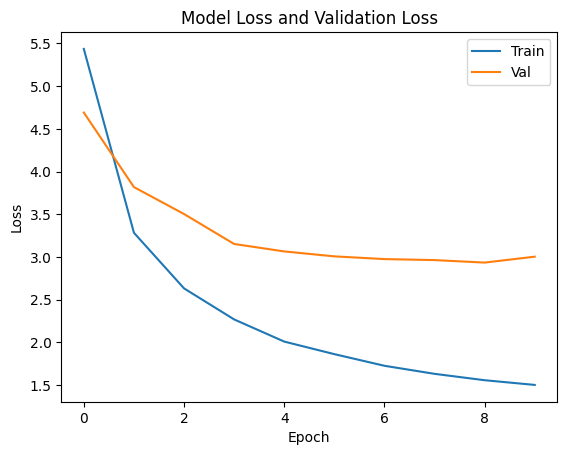

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()


##Evaluation

In [ ]:
transformer.evaluate(val_dataset)

## Translating texts

In [107]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [108]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=transformer.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [109]:
translator('What makes you think that it is not true?')


1/1 [==============================] - 0s 22ms/step


'questce qui vous fait penser que ce nest pas vrai'

In [110]:
translator('Have you ever watched soccer under the rain?')

1/1 [==============================] - 0s 23ms/step


'astu déjà regardé le [UNK]'

In [111]:
translator("what is your name?")

1/1 [==============================] - 0s 23ms/step


'ton nom est ton nom de famille'

In [112]:
translator('Great trees do not grow with ease, the stronger the winds, the stronger the trees')

1/1 [==============================] - 0s 25ms/step


'de nombreuses arbres ne sapplique pas avec un fort fort'

Its not bad considering less training

# Visualizing attention scores

## Plots

In [53]:
def visualize(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken je lai fait très bien'

  tokenized_shifted_target=french_vectorize_layer([shifted_target])
  attention_weights=attention_score_model.predict([tokenized_english_sentence,
                                                   tokenized_shifted_target])

  return attention_weights

out=visualize('I did it very well')


1/1 [==============================] - 7s 7s/step


### Before Training

In [56]:
print(out['decoder_layer1_block2'][0].shape)

(8, 32, 32)


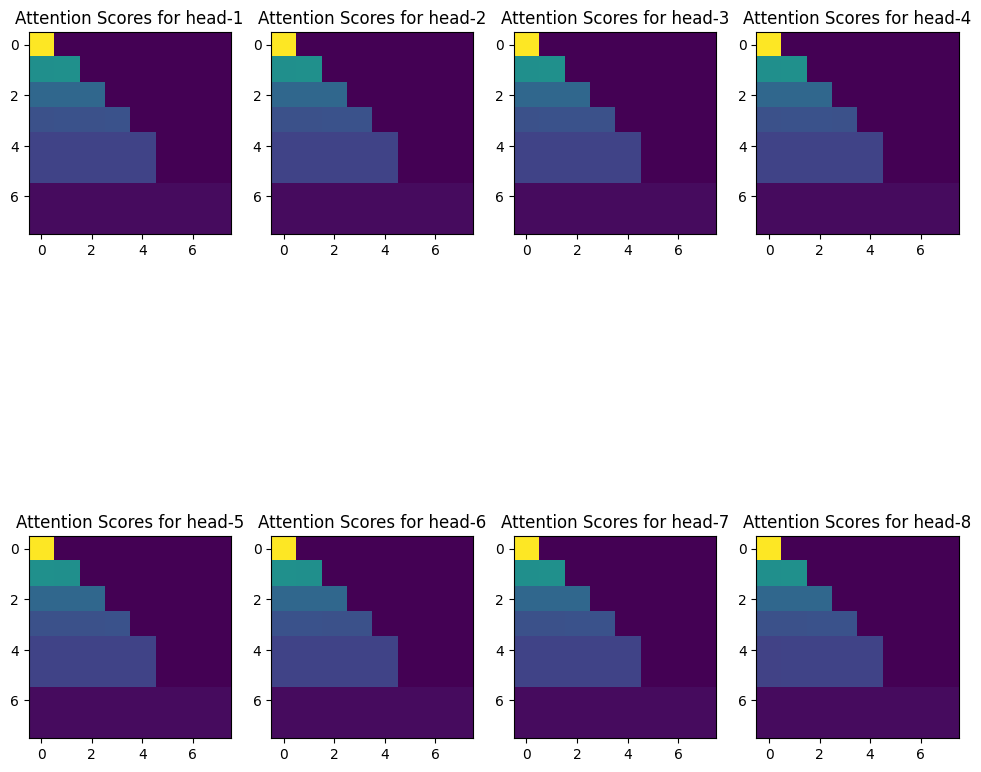

In [61]:
plt.figure(figsize = (12,12))

for i in range(NUM_HEADS):
  ax = plt.subplot(2,4, i+1)

  plt.imshow(out['decoder_layer1_block2'][0][i][0:8,0:8])
  plt.title("Attention Scores for head-"+str(i+1))


Before Training the attention scores as shown above, All of the attention seems shared and equal at first becuase its not trained yet.

### After Training

In [121]:
out2 = visualize('I did it very well')
print(out2['decoder_layer1_block2'][0].shape)

1/1 [==============================] - 0s 20ms/step
(8, 32, 32)


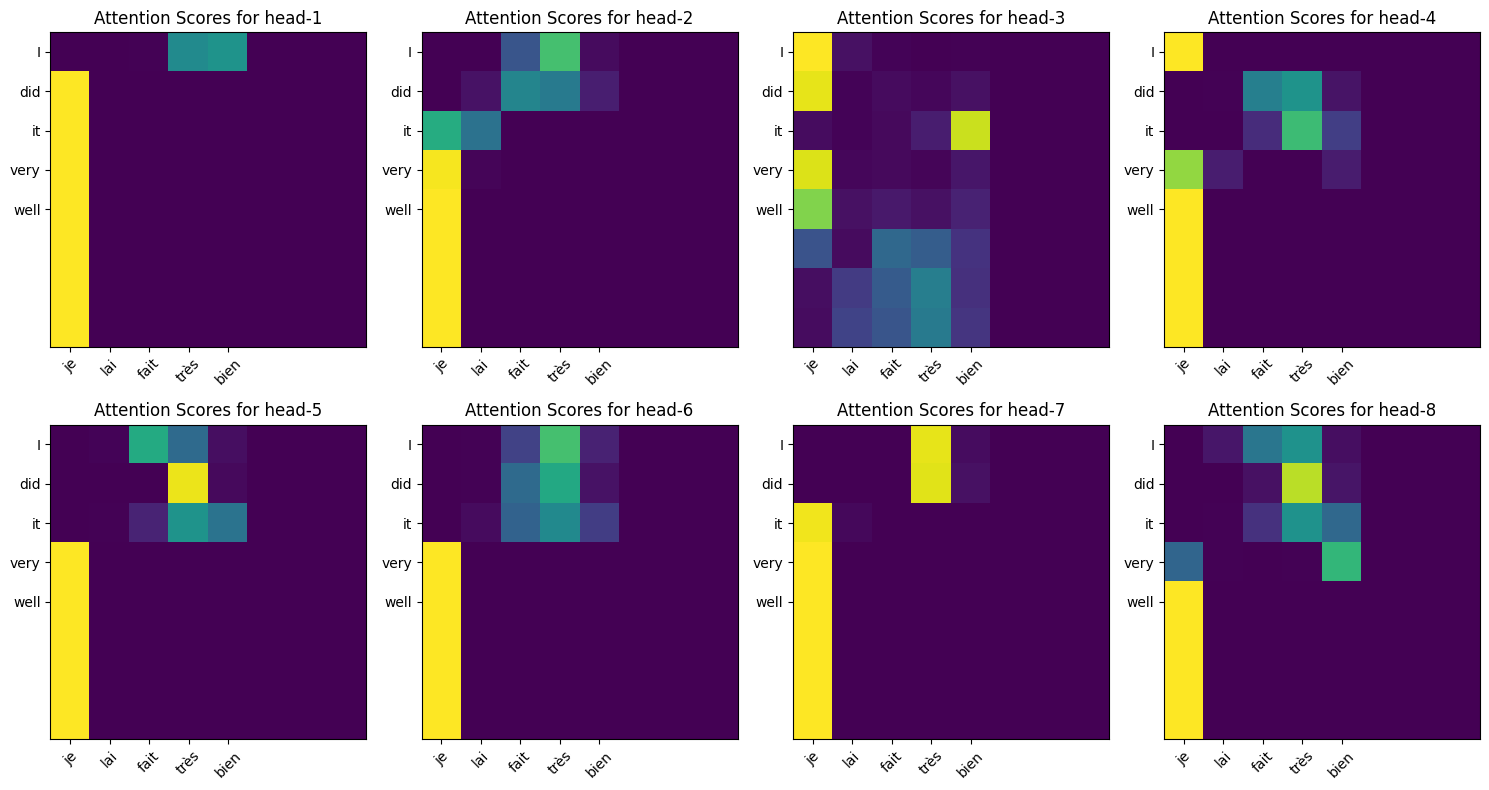

In [129]:
plt.figure(figsize=(15, 8))

for i in range(NUM_HEADS):
    ax = plt.subplot(2, 4, i + 1)

    attention_scores = out2['decoder_layer1_block2'][0][i][0:8, 0:8]

    english_words = ['I', 'did', 'it', 'very', 'well']
    french_words = ['je', 'lai', 'fait', 'très', 'bien']

    plt.imshow(attention_scores, cmap='viridis', aspect='auto')
    plt.xticks(range(len(french_words)), french_words, rotation=45)
    plt.yticks(range(len(english_words)), english_words)
    plt.title("Attention Scores for head-" + str(i + 1))

plt.tight_layout()
plt.show()

Just after the Two epochs the attention weights start to shift and each token in context to the other starts showing some kind of hierarchy.